In [40]:
import yfinance as yf
import pandas as pd
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import unicodedata
from datetime import datetime, time, timedelta
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
# ==== BACA DATA ====
# List of stock tickers (Indonesian example)
# stocks = ["BBRI.JK", "BMRI.JK", "TLKM.JK"]
lq45_stocks = [
    "ACES.JK", "ADMR.JK", "ADRO.JK", "AKRA.JK", "AMMN.JK", "AMRT.JK", "ANTM.JK", "ARTO.JK", 
    "ASII.JK", "BBCA.JK", "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK", "BRPT.JK", 
    "BUKA.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK", "GOTO.JK", "ICBP.JK", "INCO.JK", "INDF.JK", 
    "INKP.JK", "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK", "MAPI.JK", "MBMA.JK", 
    "MDKA.JK", "MEDC.JK", "MTEL.JK", "PGAS.JK", "PGEO.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK", 
    "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"
]


def get_stock_data(stock):
    """Fetch financial metrics, historical returns, and all closing prices with timestamps for a stock."""
    try:
        # Initialize ticker object
        stock_data = yf.Ticker(stock)

        # Fetch financials (ROA and ROE calculation)
        income_statement = stock_data.financials
        balance_sheet = stock_data.balance_sheet

        # Extract Net Income, Total Assets, and Shareholder's Equity
        net_income = income_statement.loc["Net Income"].iloc[0] if "Net Income" in income_statement.index else None
        total_assets = balance_sheet.loc["Total Assets"].iloc[0] if "Total Assets" in balance_sheet.index else None
        shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else None

        roa = net_income / total_assets if total_assets else None
        roe = net_income / shareholders_equity if shareholders_equity else None

        # Fetch market capitalization
        market_cap = stock_data.info.get("marketCap", None)

        # Fetch historical data for returns calculation and closing prices
        hist_data = stock_data.history(period="1y")  # Last 1 year of data
        hist_data["Daily Return"] = hist_data["Close"].pct_change()

        mean_return = hist_data["Daily Return"].mean() if not hist_data["Daily Return"].isnull().all() else None
        variance_return = hist_data["Daily Return"].var() if not hist_data["Daily Return"].isnull().all() else None

        # Get all closing prices with timestamps
        closing_prices_with_timestamps = hist_data[["Close"]].reset_index()  # Reset index to include dates
        # Convert the 'Date' to the desired format 'Y-m-d'
        closing_prices_with_timestamps["Date"] = closing_prices_with_timestamps["Date"].dt.strftime('%Y-%m-%d')

        closing_prices_with_timestamps = closing_prices_with_timestamps[["Date", "Close"]].to_dict(orient='records')  # Convert to list of dicts

        if stock =='MEDC.JK':
            roa = 0.0510
            roe = 0.2169
        return {
            "Ticker": stock,
            "ROA": roa,
            "ROE": roe,  # Updated to include ROA, but you may need to replace with correct ROE
            "Market Cap": market_cap,
            "Mean Return": mean_return,
            "Variance Return": variance_return,
            "Closing Prices with Timestamps": closing_prices_with_timestamps,
        }
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        return {
            "Ticker": stock,
            "ROA": None,
            "ROE": None,
            "Market Cap": None,
            "Mean Return": None,
            "Variance Return": None,
            "Closing Prices with Timestamps": None,
        }

# Loop through all tickers and collect data
# results = [get_stock_data(stock) for stock in lq45_stocks]
# df = pd.DataFrame(results)
# df

# Optionally, save to CSV for future use:
# # df.to_csv("New_Data Saham dan Finansial LQ45.csv", index = False)


In [39]:
data = pd.read_csv("New_Data Saham dan Finansial LQ45.csv")
data.set_index("Ticker", inplace=True)
data.drop(['Closing Prices with Timestamps'], axis = 1, inplace = True)
data.head()

,ROA,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,,
ACES.JK,0.098476,0.124282,13182707957760,0.000655,0.000534
ADMR.JK,0.260126,0.451713,53555809484800,0.000354,0.000646
ADRO.JK,0.156735,0.242362,71052591890432,0.002643,0.000822
AKRA.JK,0.091898,0.246865,25658361118720,0.000129,0.000345
AMMN.JK,0.027717,0.055417,683483982725120,0.001989,0.000777


In [376]:
scaler = StandardScaler()
df_scaled1 = pd.DataFrame(scaler.fit_transform(data), columns = scaler.get_feature_names_out(), index = data.index)
df_scaled = df_scaled1.drop(['Cluster', 'sharpe_ratio', 'ROA'], axis = 1)

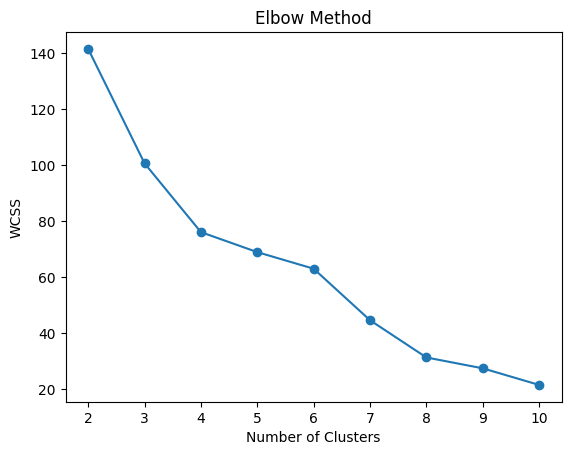

In [377]:
wcss = []

# Specify the range of cluster numbers to try
num_clusters_range = range(2, 11)

# Perform K-Means clustering for different numbers of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=26)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(num_clusters_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

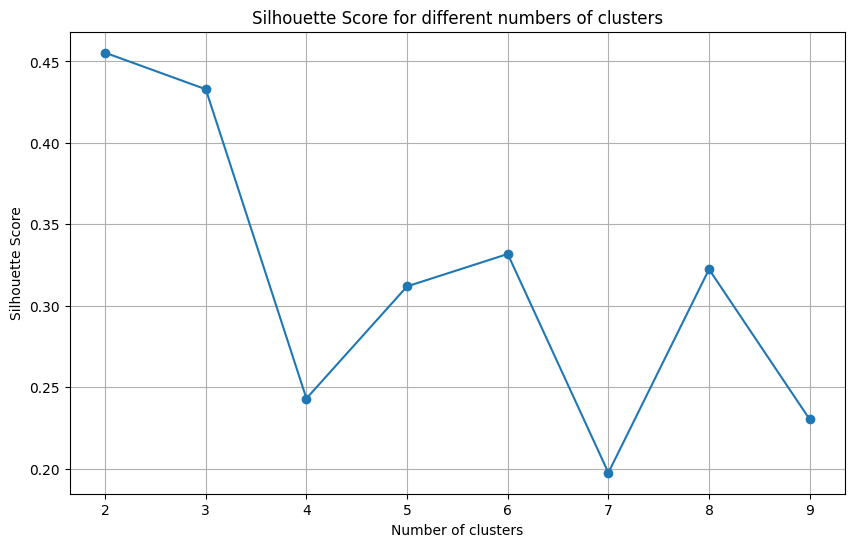

In [378]:
silhouette_scores = []
cluster_range = range(2, 10)  # Ubah range ini sesuai kebutuhan Anda

for n_clusters in cluster_range:
    km_cluster = KMeans(n_clusters = n_clusters, random_state = 5)
    cluster_labels = km_cluster.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 4. Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [241]:

kmeans_cluster = KMeans(n_clusters = 3,random_state=5)
cluster_labels = kmeans_cluster.fit_predict(df_scaled)

# 4. Calculate Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
davies_bouldin_avg = davies_bouldin_score(df_scaled, cluster_labels)
calinski_harabasz_avg = calinski_harabasz_score(df_scaled, cluster_labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg}')

# 5. Add cluster labels to the original DataFrame (optional)
data['Cluster'] = cluster_labels

Silhouette Score: 0.4329069355976914
Davies-Bouldin Index: 1.2116538101524514
Calinski-Harabasz Index: 14.8383282112269


In [242]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
BRIS.JK  0.016129  0.147235  137004020924416     0.002639         0.000720   

         Cluster  sharpe_ratio  
Ticker                          
AMMN.JK        0      0.062818  
PGAS.JK        1      0.097624  
BRIS.JK        2      0.089507  


# Cluster Analysis

In [270]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

In [374]:
df_final = df_scaled1.drop(['Cluster', 'sharpe_ratio', 'ROA'], axis = 1)
df_final.head()

,ROE,Market Cap,Mean Return,Variance Return
Ticker,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084
ADMR.JK,0.778213,-0.325757,0.133485,0.311211
ADRO.JK,0.293330,-0.248688,2.254371,0.823429
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337
AMMN.JK,-0.139658,2.448907,1.647973,0.691505


# KMeans

In [ ]:
# Opsional: Tuning parameter eps dan min_samples
df_kme = df_final.copy()

# GMM
kmeans = KMeans(n_clusters = 2, random_state = 90)
kmeans.fit(df_kme)
labelsom = kmeans.predict(df_kme)

unique_labels = np.unique(labelsom)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelsom)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_kme, labelsom)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_kme, labelsom)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_kme, labelsom)}')

df_kme['cluster'] = labelsom
data['Cluster'] = labelsom

print(df_kme.cluster.value_counts())
df_kme.head()

Clusters present: [0 1]
Clusters sizes: [41  4] 

Silhouette Score: 0.45533163637971996
Calinski-Harabasz Index: 11.732549290210736
Davies-Bouldin Index: 0.8957166291211325


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [335]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   
INCO.JK  0.093757  0.106972   38364870868992    -0.000548         0.000602   
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   

         Cluster  sharpe_ratio  
Ticker                          
AMMN.JK        0      0.062818  
INCO.JK        1     -0.032034  
PGAS.JK        2      0.097624  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

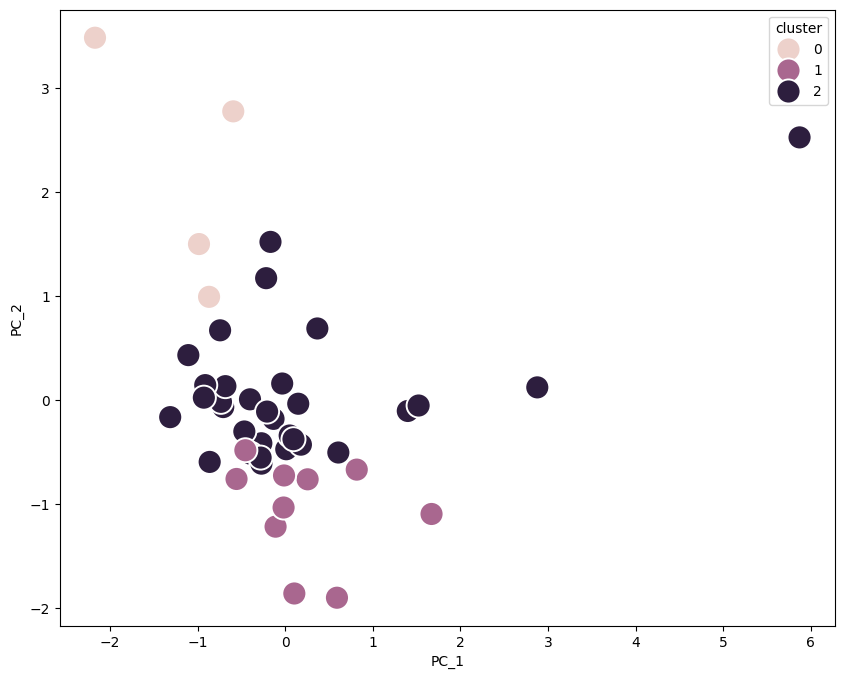

In [336]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_kme.index)

df_pca2 = pd.concat([df_pca2, df_kme.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [337]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_kme.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_kme.index)

df_pca_3 = pd.concat([df_pca_3, df_kme.cluster], axis = 1)
# df_pca1.head()

In [338]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,2
ADMR.JK,-0.271514,-0.415203,-0.497805,2
ADRO.JK,-0.216669,1.171590,-2.045702,2
AKRA.JK,-0.391026,-0.516436,-0.168712,2
AMMN.JK,-0.591894,2.775036,0.198475,0


In [339]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Gaussian Mixture

In [ ]:
# Opsional: Tuning parameter eps dan min_samples
df_gmm = df_final.copy()

# GMM
gmm = GaussianMixture(n_components = 3, random_state=0)
gmm.fit(df_gmm)
labelsom = gmm.predict(df_gmm)

unique_labels = np.unique(labelsom)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Clusters sizes: {np.bincount(labelsom)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_gmm, labelsom)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_gmm, labelsom)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_gmm, labelsom)}')

df_gmm['cluster'] = labelsom
data['Cluster'] = labelsom

print(df_gmm.cluster.value_counts())
df_gmm.head()

Clusters present: [0 1 2]
Clusters sizes: [40  1  4] 

Silhouette Score: 0.4902636420089914
Calinski-Harabasz Index: 19.63209953997143
Davies-Bouldin Index: 0.627493894362586
cluster
0    40
2     4
1     1
Name: count, dtype: int64


,ROA,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.252813,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.860011,-0.325757,0.133485,0.311211,0
ADRO.JK,0.471649,-0.248688,2.254371,0.823429,0
AKRA.JK,0.228107,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.012974,2.448907,1.647973,0.691505,2


In [341]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
GOTO.JK        1     -0.007451  
AMMN.JK        2      0.062818  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

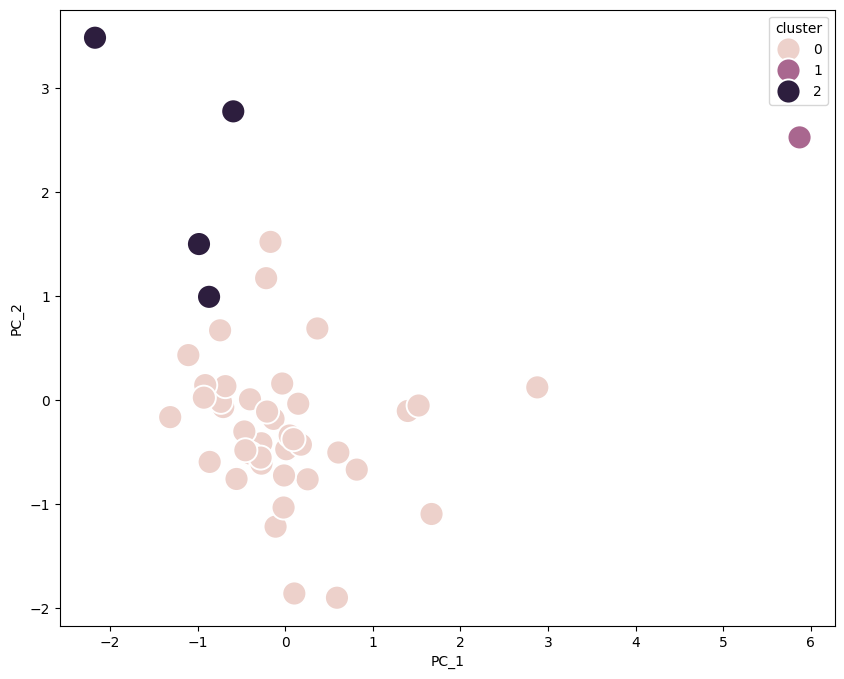

In [342]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_gmm.index)

df_pca2 = pd.concat([df_pca2, df_gmm.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [343]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_gmm.index)

df_pca_3 = pd.concat([df_pca_3, df_gmm.cluster], axis = 1)
# df_pca1.head()

In [344]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,0
ADMR.JK,-0.271514,-0.415203,-0.497805,0
ADRO.JK,-0.216669,1.171590,-2.045702,0
AKRA.JK,-0.391026,-0.516436,-0.168712,0
AMMN.JK,-0.591894,2.775036,0.198475,2


In [345]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# OPTICS

In [387]:
import numpy as np
import pandas as pd
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_optics = df_final.copy()

# Apply OPTICS clustering
optics = OPTICS(min_samples=5, xi=0.001, min_cluster_size=0.001)
optics.fit(df_optics)

# Extract labels and number of clusters
labels = optics.labels_

# Calculate metrics
unique_labels = np.unique(labels)
n_clusters_formed = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Clusters present: {unique_labels}')
print(f'Number of clusters formed: {n_clusters_formed}')
print(f'Clusters sizes: {np.bincount(labels + 1)}', '\n')  # +1 to include noise as a category

# Calculate and print clustering evaluation metrics, excluding noise
non_noise_indices = labels != -1
if n_clusters_formed > 1:  # Metrics are meaningful when there is more than one cluster
    print(f'Silhouette Score: {silhouette_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
    print(f'Davies-Bouldin Index: {davies_bouldin_score(df_optics[non_noise_indices], labels[non_noise_indices])}')
else:
    print("Not enough clusters formed for meaningful evaluation metrics.")

# Add cluster labels to the DataFrame
df_optics['cluster'] = labels
data['Cluster'] = labels

# Show the cluster counts
print(df_optics['cluster'].value_counts())
df_optics.head()


Clusters present: [-1  0  1]
Number of clusters formed: 2
Clusters sizes: [29 13  3] 

Silhouette Score: 0.21355984151956275
Calinski-Harabasz Index: 4.904944281786961
Davies-Bouldin Index: 1.0072188008483716
cluster
-1    29
 0    13
 1     3
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,-1
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,-1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,-1


In [388]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE      Market Cap  Mean Return  Variance Return  \
Ticker                                                                      
PGAS.JK  0.042140  0.103040  38422777430016     0.002017         0.000332   
ISAT.JK  0.039281  0.146569  81272013586432     0.000728         0.000563   
MTEL.JK  0.035263  0.059062  55146499276800    -0.000203         0.000313   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK       -1      0.097624  
ISAT.JK        0      0.020657  
MTEL.JK        1     -0.024914  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

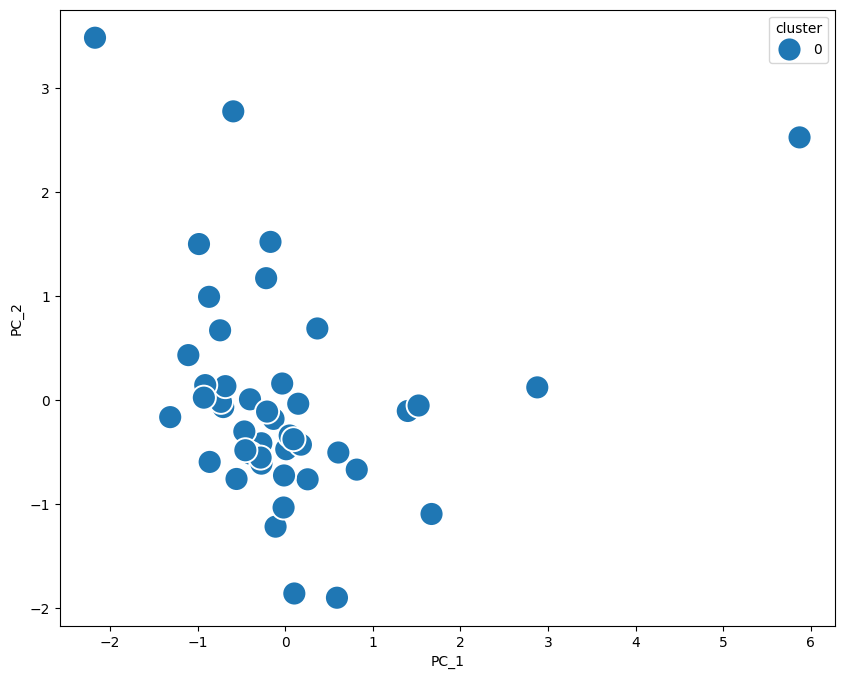

In [347]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_optics.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_optics.index)

df_pca2 = pd.concat([df_pca2, df_optics.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

In [348]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_optics.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_optics.index)

df_pca_3 = pd.concat([df_pca_3, df_optics.cluster], axis = 1)
# df_pca1.head()

# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# # klaster 3
# Cluster2= go.Scatter3d(
#         x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
#         y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
#         z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
#         mode="markers",
#         marker=dict(
#                     size=10,
#                     color="rgb(0,0,255)",
#         ),
#         name="Cluster 2"
# )
# klaster noise
Cluster3= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==-1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==-1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==-1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,225,0)",
        ),
        name="Cluster Noise"
)

data_plot_km=[Cluster0,Cluster1,Cluster3]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# BIRCH

In [349]:
import numpy as np
import pandas as pd
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_birch = df_final.copy()

# Apply BIRCH clustering
birch = Birch(n_clusters=3)
birch.fit(df_birch)

# Extract labels
labels = birch.labels_

# Calculate metrics
unique_labels = np.unique(labels)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
print(f'Number of clusters formed: {n_clusters_formed}')
print(f'Clusters sizes: {np.bincount(labels)}', '\n')

# Calculate and print clustering evaluation metrics
print(f'Silhouette Score: {silhouette_score(df_birch, labels)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_birch, labels)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_birch, labels)}')

# Add cluster labels to the DataFrame
df_birch['cluster'] = labels
data['Cluster'] = labels

# Show the cluster counts
print(df_birch['cluster'].value_counts())
df_birch.head()


Clusters present: [0 1 2]
Number of clusters formed: 3
Clusters sizes: [40  1  4] 

Silhouette Score: 0.4902636420089914
Calinski-Harabasz Index: 19.63209953997143
Davies-Bouldin Index: 0.627493894362586
cluster
0    40
2     4
1     1
Name: count, dtype: int64


,ROA,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.252813,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.860011,-0.325757,0.133485,0.311211,0
ADRO.JK,0.471649,-0.248688,2.254371,0.823429,0
AKRA.JK,0.228107,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.012974,2.448907,1.647973,0.691505,2


In [350]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
GOTO.JK        1     -0.007451  
AMMN.JK        2      0.062818  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

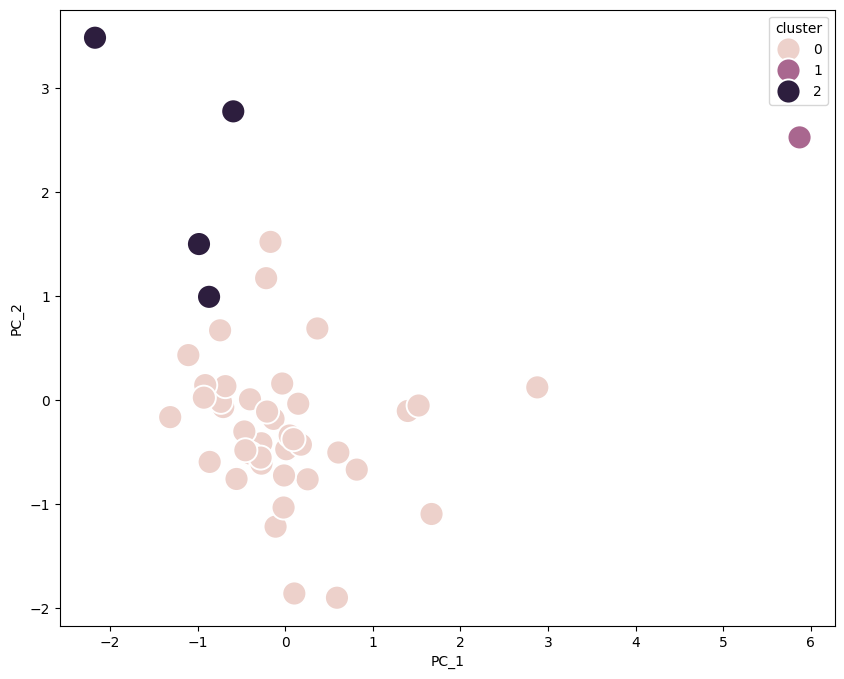

In [351]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_birch.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_birch.index)

df_pca2 = pd.concat([df_pca2, df_birch.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

In [352]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_birch.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_birch.index)

df_pca_3 = pd.concat([df_pca_3, df_birch.cluster], axis = 1)
# df_pca1.head()

# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)
data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Spectral Clustering

Explained variance by PCA: 65.08%


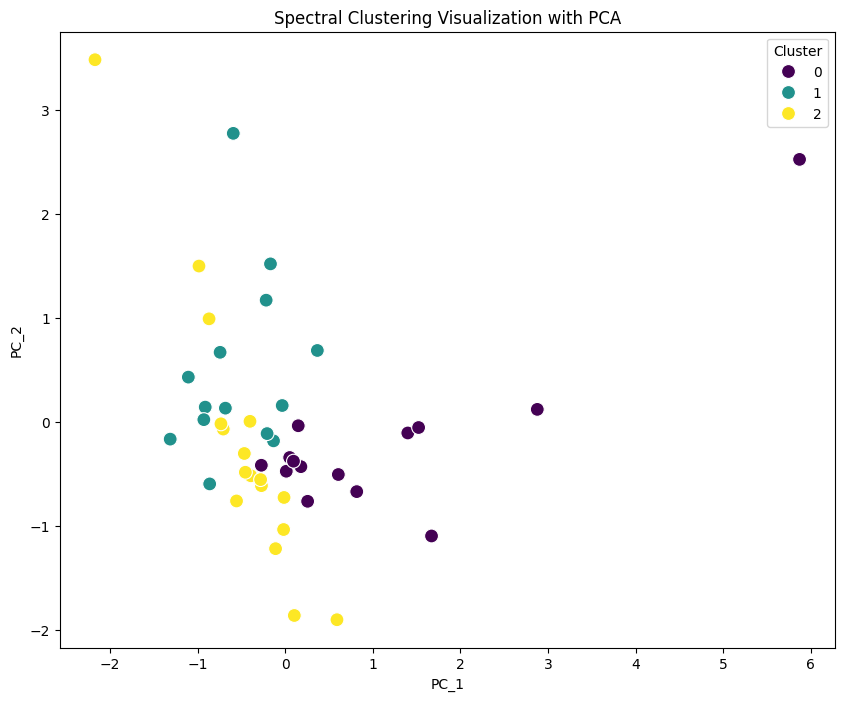

Cluster: cluster
2    17
1    14
0    14
Name: count, dtype: int64
Calinski-Harabasz Index: 8.323602467931405
Silhouette Score: 0.16607322108625736
Davies-Bouldin Index: 1.5143795469007026


In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Assuming df_final is your DataFrame with features for clustering
df_spec = df_final.copy()
X_std = df_final.copy().values  # Convert DataFrame to NumPy array

# Apply Spectral Clustering
n_clusters = 3  # Specify the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
labels = spectral.fit_predict(X_std)

# Add cluster labels to DataFrame
df_spec['cluster'] = labels
data['Cluster'] = labels

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:, :-1]),
                      columns=['PC_1', 'PC_2'],
                      index=df_spec.index)

df_pca2 = pd.concat([df_pca2, df_spec['cluster']], axis=1)

# Print the explained variance ratio
print(f"Explained variance by PCA: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data=df_pca2, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, ax=ax)
plt.title('Spectral Clustering Visualization with PCA')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.legend(title='Cluster')
plt.show()

# Compute and print clustering evaluation metrics
print(f'Cluster: {df_spec['cluster'].value_counts()}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(X_std, labels)}')
print(f'Silhouette Score: {silhouette_score(X_std, labels)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(X_std, labels)}')


In [354]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE        Market Cap  Mean Return  Variance Return  \
Ticker                                                                        
MEDC.JK  0.051000  0.216900    27071927549952     0.000651         0.000627   
PGAS.JK  0.042140  0.103040    38422777430016     0.002017         0.000332   
BBCA.JK  0.034542  0.200693  1241995691425792     0.000782         0.000194   

         Cluster  sharpe_ratio  
Ticker                          
MEDC.JK        0      0.016501  
PGAS.JK        1      0.097624  
BBCA.JK        2      0.039002  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

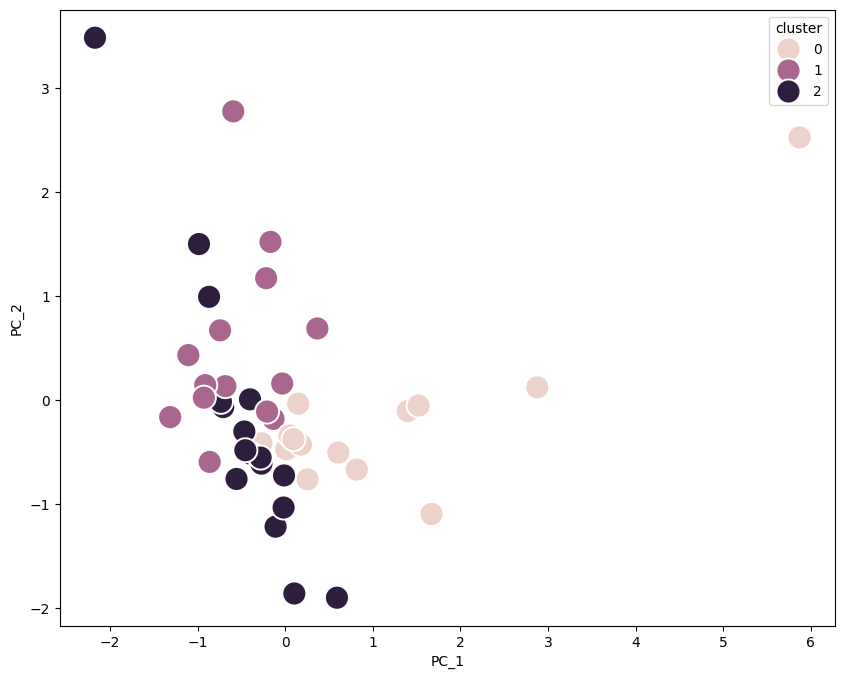

In [355]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_spec.index)

df_pca2 = pd.concat([df_pca2, df_spec.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [356]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_spec.index)

df_pca_3 = pd.concat([df_pca_3, df_spec.cluster], axis = 1)
# df_pca1.head()

In [357]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,1
ADMR.JK,-0.271514,-0.415203,-0.497805,0
ADRO.JK,-0.216669,1.171590,-2.045702,1
AKRA.JK,-0.391026,-0.516436,-0.168712,2
AMMN.JK,-0.591894,2.775036,0.198475,1


In [358]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# Agglomerative

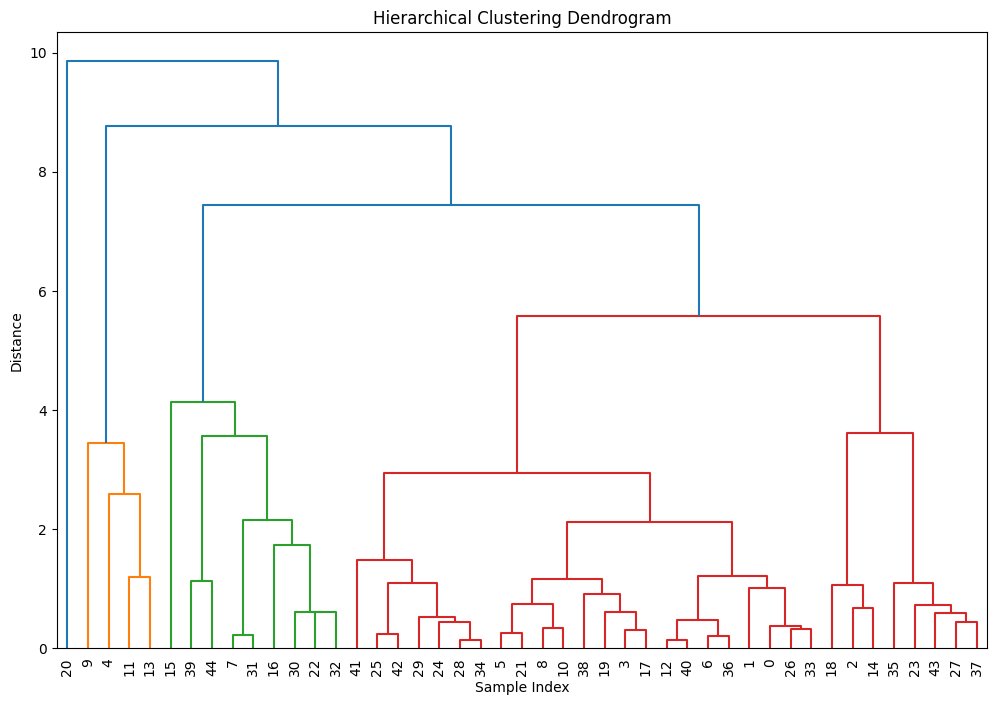

In [359]:
# Assuming df_std is your standardized DataFrame
df_agl1 = df_final.copy()

# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=1)
labelagl1 = agglomerative.fit_predict(df_agl1)
df_agl1['cluster'] = labelagl1

# Compute the linkage matrix
linkage_matrix = linkage(df_agl1.drop(columns=['cluster']), method='ward')

# Plot the dendrogram with all data points
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [360]:
df_agl = df_final.copy()

agglomerative = AgglomerativeClustering(n_clusters=3, metric = 'euclidean',linkage='ward')
labelagl = agglomerative.fit_predict(df_agl)

# Periksa apakah terdapat cluster yang terbentuk
unique_labels = np.unique(labelagl)
n_clusters_formed = len(unique_labels)
if n_clusters_formed > 1:  # Cek apakah terdapat lebih dari satu klaster yang terbentuk
    score = silhouette_score(df_agl, labelagl)
    print(f'Clusters present: {unique_labels}')
    print(f'Clusters sizes: {np.bincount(labelagl)}', '\n')
    print(f'Silhouette Score: {silhouette_score(df_agl, labelagl)}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_agl, labelagl)}')
    print(f'Davies-Bouldin Index: {davies_bouldin_score(df_agl, labelagl)}')
else:
    print("Tidak ada klaster yang terbentuk dengan parameter ini.\n")

df_agl['cluster'] = labelagl
data['Cluster'] = labelagl

Clusters present: [0 1 2]
Clusters sizes: [40  1  4] 

Silhouette Score: 0.4902636420089914
Calinski-Harabasz Index: 19.63209953997143
Davies-Bouldin Index: 0.627493894362586


In [361]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
GOTO.JK -1.670984 -2.383206   91717776703488    -0.000042         0.001415   
AMMN.JK  0.027717  0.055417  683483982725120     0.001989         0.000777   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK        0      0.097624  
GOTO.JK        1     -0.007451  
AMMN.JK        2      0.062818  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

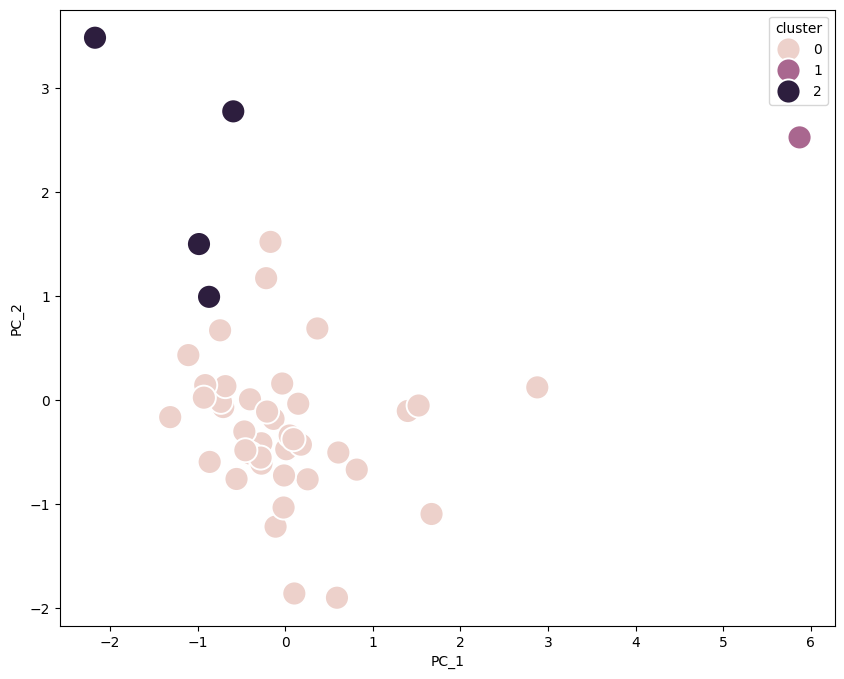

In [362]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_agl.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_agl.index)

df_pca2 = pd.concat([df_pca2, df_agl.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [363]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_agl.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_agl.index)

df_pca_3 = pd.concat([df_pca_3, df_agl.cluster], axis = 1)
# df_pca1.head()

In [364]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,0
ADMR.JK,-0.271514,-0.415203,-0.497805,0
ADRO.JK,-0.216669,1.171590,-2.045702,0
AKRA.JK,-0.391026,-0.516436,-0.168712,0
AMMN.JK,-0.591894,2.775036,0.198475,2


In [365]:
# membuat visualisasi 3D untuk setiap klaster

# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

In [366]:
df_agl

,ROA,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.252813,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.860011,-0.325757,0.133485,0.311211,0
ADRO.JK,0.471649,-0.248688,2.254371,0.823429,0
AKRA.JK,0.228107,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.012974,2.448907,1.647973,0.691505,2
AMRT.JK,0.256240,-0.000140,0.214998,-0.718876,0
ANTM.JK,0.152693,-0.406057,-0.210453,-0.078249,0
ARTO.JK,-0.104323,-0.399909,-0.199115,1.716608,0
ASII.JK,0.168114,0.347773,-0.112428,-0.815975,0


# DBSCAN

In [ ]:
# Opsional: Tuning parameter eps dan min_samples
df_som = df_final.copy()

# GMM
dbs = DBSCAN(min_samples = 3)
dbs.fit(df_som)
labelsom = dbs.labels_

unique_labels = np.unique(labelsom)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
# print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_som, labelsom)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_som, labelsom)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_som, labelsom)}')

df_som['cluster'] = labelsom
data['Cluster'] = labelsom

print(df_som.cluster.value_counts())
df_som.head()

Clusters present: [-1  0  1]
Silhouette Score: 0.07130813962183512
Calinski-Harabasz Index: 2.863437960746475
Davies-Bouldin Index: 2.207181012714297
cluster
-1    21
 0    20
 1     4
Name: count, dtype: int64


,ROE,Market Cap,Mean Return,Variance Return,cluster
Ticker,,,,,
ACES.JK,0.019841,-0.503589,0.412495,-0.015084,0
ADMR.JK,0.778213,-0.325757,0.133485,0.311211,-1
ADRO.JK,0.293330,-0.248688,2.254371,0.823429,-1
AKRA.JK,0.303760,-0.448638,-0.074903,-0.567337,0
AMMN.JK,-0.139658,2.448907,1.647973,0.691505,-1


In [382]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
ICBP.JK  0.058613  0.171547  137318870548480     0.000646         0.000286   
UNTR.JK  0.133818  0.260084  100964321198080     0.001568         0.000246   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK       -1      0.097624  
ICBP.JK        0      0.024142  
UNTR.JK        1      0.084842  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

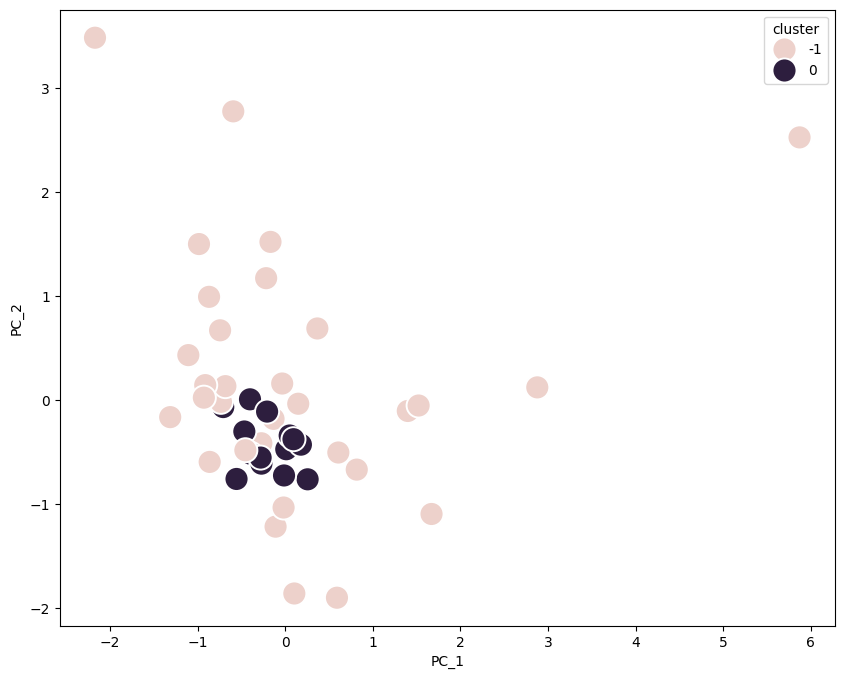

In [ ]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_som.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_som.index)

df_pca2 = pd.concat([df_pca2, df_som.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [370]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_spec.index)

df_pca_3 = pd.concat([df_pca_3, df_spec.cluster], axis = 1)
# df_pca1.head()

In [371]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,1
ADMR.JK,-0.271514,-0.415203,-0.497805,0
ADRO.JK,-0.216669,1.171590,-2.045702,1
AKRA.JK,-0.391026,-0.516436,-0.168712,2
AMMN.JK,-0.591894,2.775036,0.198475,1


In [372]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)

# SOM

In [391]:
from minisom import MiniSom

In [397]:
pd.asarray(df_final.copy())

AttributeError: module 'pandas' has no attribute 'asarray'

In [395]:
# Opsional: Tuning parameter eps dan min_samples
df_som1 = df_final.copy()
df_som = df_som1.to_numpy()

# GMM
# Train SOM
som = MiniSom(x=4, y=4, input_len=4, sigma=1.0, learning_rate=0.5)
som.random_weights_init(df_som)
som.train_random(df_som, 500)  # 500 iterations

# Get weights (codebook vectors)
codebook_vectors = som.get_weights().reshape(-1, 4)  # Flatten to (16, 3) for clustering

# Apply KMeans for custom clustering (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(codebook_vectors)

# Cluster labels for SOM units
cluster_labels = kmeans.labels_

# Get SOM dimensions
grid_shape = som.get_weights().shape  # (4, 4, 3)
x_dim, y_dim = grid_shape[0], grid_shape[1]

# Assign clusters to data points based on BMU
data_clusters = []
for d in data:
    winner = som.winner(d)  # Get BMU
    cluster = cluster_labels[winner[0] * y_dim + winner[1]]  # Map BMU to cluster
    data_clusters.append(cluster)
# Get SOM dimensions
grid_shape = som.get_weights().shape  # (4, 4, 3)
x_dim, y_dim = grid_shape[0], grid_shape[1]

# Assign clusters to data points based on BMU
data_clusters = []
for d in data:
    winner = som.winner(d)  # Get BMU
    cluster = cluster_labels[winner[0] * y_dim + winner[1]]  # Map BMU to cluster
    data_clusters.append(cluster)
    
labelsom = cluster_labels
unique_labels = np.unique(labelsom)
n_clusters_formed = len(unique_labels)
print(f'Clusters present: {unique_labels}')
# print(f'Clusters sizes: {np.bincount(labelg)}', '\n')
print(f'Silhouette Score: {silhouette_score(df_som, labelsom)}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_score(df_som, labelsom)}')
print(f'Davies-Bouldin Index: {davies_bouldin_score(df_som, labelsom)}')

df_som1['cluster'] = labelsom
data['Cluster'] = labelsom

print(df_som.cluster.value_counts())
df_som.head()

ValueError: operands could not be broadcast together with shapes (3,) (4,4,4) 

In [ ]:
# Risk-free rate (contoh: 6% per tahun, diubah ke harian)
risk_free_rate = 0.06 / 252

# Hitung Sharpe Ratio
data['sharpe_ratio'] = (data['Mean Return'] - risk_free_rate) / np.sqrt(data['Variance Return'])

# Ambil saham terbaik dari setiap cluster
best_stocks = data.loc[data.groupby('Cluster')['sharpe_ratio'].idxmax()]

print(best_stocks)

              ROA       ROE       Market Cap  Mean Return  Variance Return  \
Ticker                                                                       
PGAS.JK  0.042140  0.103040   38422777430016     0.002017         0.000332   
ICBP.JK  0.058613  0.171547  137318870548480     0.000646         0.000286   
UNTR.JK  0.133818  0.260084  100964321198080     0.001568         0.000246   

         Cluster  sharpe_ratio  
Ticker                          
PGAS.JK       -1      0.097624  
ICBP.JK        0      0.024142  
UNTR.JK        1      0.084842  


65.08414737534632 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

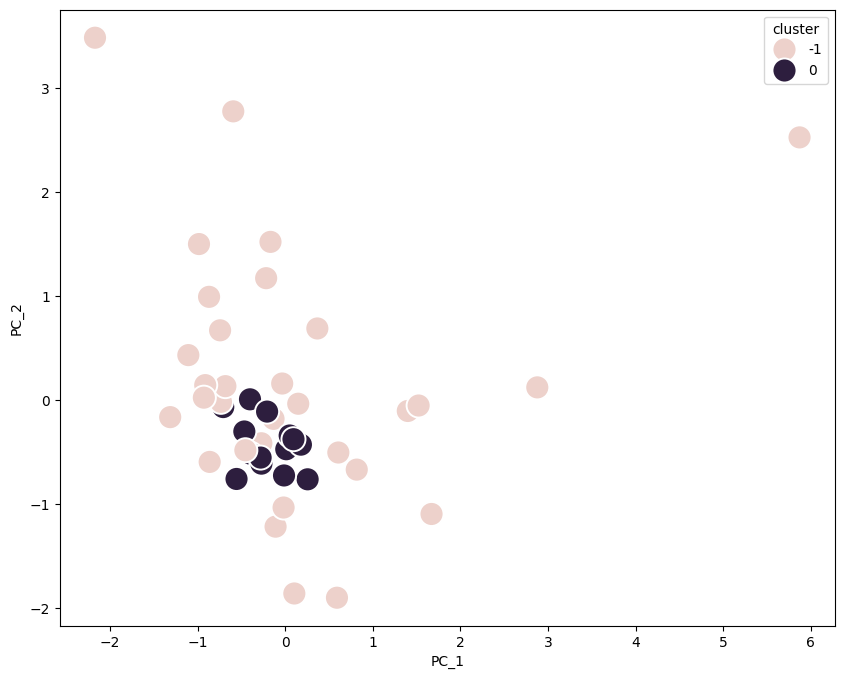

In [ ]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_som.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_som.index)

df_pca2 = pd.concat([df_pca2, df_som.cluster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'cluster', s = 300, ax = ax)

**3D**

In [ ]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

pca = PCA(n_components = 3)
df_pca_3 = pd.DataFrame(pca.fit_transform(df_spec.iloc[:,:-1]),
                      columns = ['PC1', 'PC2', 'PC3'],
                      index = df_spec.index)

df_pca_3 = pd.concat([df_pca_3, df_spec.cluster], axis = 1)
# df_pca1.head()

In [ ]:
df_pca_3.head()

,PC1,PC2,PC3,cluster
Ticker,,,,
ACES.JK,-0.132589,-0.180676,-0.661453,1
ADMR.JK,-0.271514,-0.415203,-0.497805,0
ADRO.JK,-0.216669,1.171590,-2.045702,1
AKRA.JK,-0.391026,-0.516436,-0.168712,2
AMMN.JK,-0.591894,2.775036,0.198475,1


In [ ]:
# membuat visualisasi 3D untuk setiap klaster
# klaster 1
Cluster0= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==0]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==0]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==0]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(255,0,0)",
        ),
        name="Cluster 0"
)

#klaster 2
Cluster1= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==1]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==1]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==1]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,255,0)",
        ),
        name="Cluster 1"
)

# klaster 3
Cluster2= go.Scatter3d(
        x=df_pca_3[df_pca_3['cluster']==2]['PC1'],
        y=df_pca_3[df_pca_3['cluster']==2]['PC2'],
        z=df_pca_3[df_pca_3['cluster']==2]['PC3'],
        mode="markers",
        marker=dict(
                    size=10,
                    color="rgb(0,0,255)",
        ),
        name="Cluster 2"
)


data_plot_km=[Cluster0,Cluster1,Cluster2]

# membuat plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0))

fig=go.Figure(data = data_plot_km, layout = layout)
iplot(fig)